Random Sampling
=============

Copyright 2016 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import numpy
import scipy.stats

import matplotlib.pyplot as pyplot

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# seed the random number generator so we all get the same results
numpy.random.seed(18)

# some nicer colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

%matplotlib inline

Part One
========

Suppose we want to estimate the average weight of men and women in the U.S.

And we want to quantify the uncertainty of the estimate.

One approach is to simulate many experiments and see how much the results vary from one experiment to the next.

I'll start with the unrealistic assumption that we know the actual distribution of weights in the population.  Then I'll show how to solve the problem without that assumption.

Based on data from the [BRFSS](http://www.cdc.gov/brfss/), I found that the distribution of weight in kg for women in the U.S. is well modeled by a lognormal distribution with the following parameters:

In [2]:
weight = scipy.stats.lognorm(0.23, 0, 70.8)
weight.mean(), weight.std()

(72.697645732966876, 16.944043048498038)

Here's what that distribution looks like:

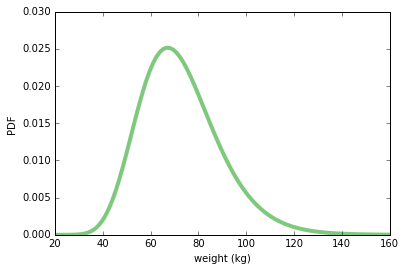

In [3]:
xs = numpy.linspace(20, 160, 100)
ys = weight.pdf(xs)
pyplot.plot(xs, ys, linewidth=4, color=COLOR1)
pyplot.xlabel('weight (kg)')
pyplot.ylabel('PDF')
None

`make_sample` draws a random sample from this distribution.  The result is a NumPy array.

In [4]:
def make_sample(n=100):
    sample = weight.rvs(n)
    return sample

Here's an example with `n=100`.  The mean and std of the sample are close to the mean and std of the population, but not exact.

In [5]:
sample = make_sample(n=100)
sample.mean(), sample.std()

(76.308293640077437, 19.995558735561865)

We want to estimate the average weight in the population, so the "sample statistic" we'll use is the mean:

In [6]:
def sample_stat(sample):
    return sample.mean()

One iteration of "the experiment" is to collect a sample of 100 women and compute their average weight.

We can simulate running this experiment many times, and collect a list of sample statistics.  The result is a NumPy array.

In [7]:
def compute_sample_statistics(n=100, iters=1000):
    stats = [sample_stat(make_sample(n)) for i in range(iters)]
    return numpy.array(stats)

The next line runs the simulation 1000 times and puts the results in
`sample_means`:

In [8]:
sample_means = compute_sample_statistics(n=100, iters=1000)

Let's look at the distribution of the sample means.  This distribution shows how much the results vary from one experiment to the next.

Remember that this distribution is not the same as the distribution of weight in the population.  This is the distribution of results across repeated imaginary experiments.

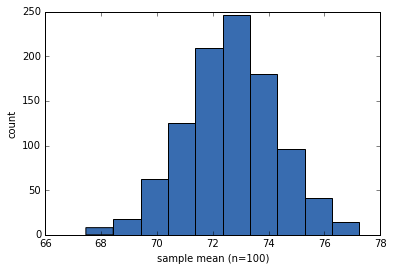

In [9]:
pyplot.hist(sample_means, color=COLOR5)
pyplot.xlabel('sample mean (n=100)')
pyplot.ylabel('count')
None

The mean of the sample means is close to the actual population mean, which is nice, but not actually the important part.

In [10]:
sample_means.mean()

72.652052080657413

The standard deviation of the sample means quantifies the variability from one experiment to the next, and reflects the precision of the estimate.

This quantity is called the "standard error".

In [11]:
std_err = sample_means.std()
std_err

1.6355262477017491

We can also use the distribution of sample means to compute a "90% confidence interval", which contains 90% of the experimental results:

In [12]:
conf_int = numpy.percentile(sample_means, [5, 95])
conf_int

array([ 69.92149384,  75.40866638])

The following function takes an array of sample statistics and prints the SE and CI:

In [13]:
def summarize_sampling_distribution(sample_stats):
    print('SE', sample_stats.std())
    print('90% CI', numpy.percentile(sample_stats, [5, 95]))

And here's what that looks like:

In [14]:
summarize_sampling_distribution(sample_means)

SE 1.6355262477
90% CI [ 69.92149384  75.40866638]


Now we'd like to see what happens as we vary the sample size, `n`.  The following function takes `n`, runs 1000 simulated experiments, and summarizes the results.

In [15]:
def plot_sample_stats(n, xlim=None):
    sample_stats = compute_sample_statistics(n, iters=1000)
    summarize_sampling_distribution(sample_stats)
    pyplot.hist(sample_stats, color=COLOR2)
    pyplot.xlabel('sample statistic')
    pyplot.xlim(xlim)

Here's a test run with `n=100`:

SE 1.71202891175
90% CI [ 69.96057332  75.58582662]


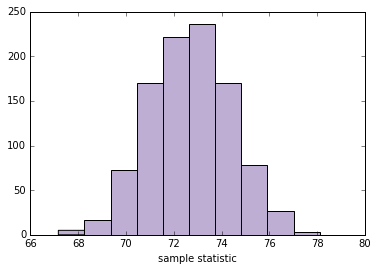

In [16]:
plot_sample_stats(100)

Now we can use `interact` to run `plot_sample_stats` with different values of `n`.  Note: `xlim` sets the limits of the x-axis so the figure doesn't get rescaled as we vary `n`.

SE 0.525503877916
90% CI [ 71.87445855  73.56791911]


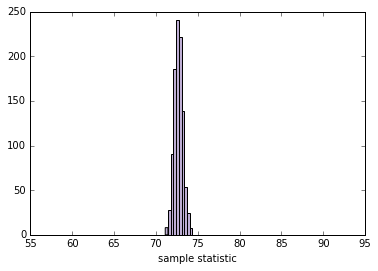

In [17]:
def sample_stat(sample):
    return sample.mean()

slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_sample_stats, n=slider, xlim=fixed([55, 95]))
None

### Other sample statistics

This framework works with any other quantity we want to estimate.  By changing `sample_stat`, you can compute the SE and CI for any sample statistic.

**Exercise 1**: Fill in `sample_stat` below with any of these statistics:

* Standard deviation of the sample.
* Coefficient of variation, which is the sample standard deviation divided by the sample standard mean.
* Min or Max
* Median (which is the 50th percentile)
* 10th or 90th percentile.
* Interquartile range (IQR), which is the difference between the 75th and 25th percentiles.

NumPy array methods you might find useful include `std`, `min`, `max`, and `percentile`.
Depending on the results, you might want to adjust `xlim`.

SE 0.00571641696402
90% CI [ 0.22360129  0.2427209 ]


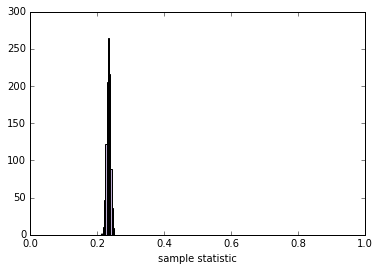

In [21]:
def sample_stat(sample):
    # TODO: replace the following line with another sample statistic
    return sample.std()/sample.mean()

slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_sample_stats, n=slider, xlim=fixed([0, 1]))
None

STOP HERE
---------

We will regroup and discuss before going on.

Part Two
========

So far we have shown that if we know the actual distribution of the population, we can compute the sampling distribution for any sample statistic, and from that we can compute SE and CI.

But in real life we don't know the actual distribution of the population.  If we did, we wouldn't need to estimate it!

In real life, we use the sample to build a model of the population distribution, then use the model to generate the sampling distribution.  A simple and popular way to do that is "resampling," which means we use the sample itself as a model of the population distribution and draw samples from it.

Before we go on, I want to collect some of the code from Part One and organize it as a class.  This class represents a framework for computing sampling distributions.

In [22]:
class Resampler(object):
    """Represents a framework for computing sampling distributions."""
    
    def __init__(self, sample, xlim=None):
        """Stores the actual sample."""
        self.sample = sample
        self.n = len(sample)
        self.xlim = xlim
        
    def resample(self):
        """Generates a new sample by choosing from the original
        sample with replacement.
        """
        new_sample = numpy.random.choice(self.sample, self.n, replace=True)
        return new_sample
    
    def sample_stat(self, sample):
        """Computes a sample statistic using the original sample or a
        simulated sample.
        """
        return sample.mean()
    
    def compute_sample_statistics(self, iters=1000):
        """Simulates many experiments and collects the resulting sample
        statistics.
        """
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return numpy.array(stats)
    
    def plot_sample_stats(self):
        """Runs simulated experiments and summarizes the results.
        """
        sample_stats = self.compute_sample_statistics()
        summarize_sampling_distribution(sample_stats)
        pyplot.hist(sample_stats, color=COLOR2)
        pyplot.xlabel('sample statistic')
        pyplot.xlim(self.xlim)

The following function instantiates a `Resampler` and runs it.

In [23]:
def plot_resampled_stats(n=100):
    sample = weight.rvs(n)
    resampler = Resampler(sample, xlim=[55, 95])
    resampler.plot_sample_stats()

Here's a test run with `n=100`

SE 1.88213747201
90% CI [ 69.20383871  75.41273002]


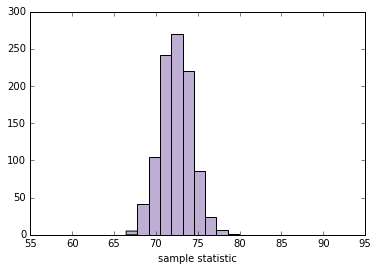

In [24]:
plot_resampled_stats(100)

Now we can use `plot_resampled_stats` in an interaction:

In [ ]:
slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_resampled_stats, n=slider, xlim=fixed([1, 15]))
None

**Exercise 2**: write a new class called `StdResampler` that inherits from `Resampler` and overrides `sample_stat` so it computes the standard deviation of the resampled data.

In [26]:
class StdResampler(Resampler):
    def sample_stat(self, sample):
        return sample.std()

Test your code using the cell below:

SE 1.04269288328
90% CI [ 14.36170462  17.69668244]


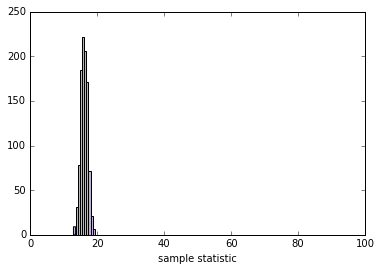

In [27]:
def plot_resampled_stats(n=100):
    sample = weight.rvs(n)
    resampler = StdResampler(sample, xlim=[0, 100])
    resampler.plot_sample_stats()
    
plot_resampled_stats()

When your `StdResampler` is working, you should be able to interact with it:

SE 4.14346305598
90% CI [ 11.3568876   24.56949401]


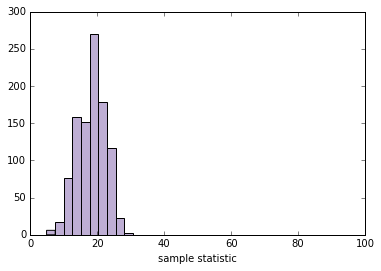

In [29]:
slider = widgets.IntSlider(min=10, max=1000, value=100)
interact(plot_resampled_stats, n=slider)
None

STOP HERE
---------

We will regroup and discuss before going on.

Part Three
==========

We can extend this framework to compute SE and CI for a difference in means.

For example, men are heavier than women on average.  Here's the women's distribution again (from BRFSS data):

In [ ]:
female_weight = scipy.stats.lognorm(0.23, 0, 70.8)
female_weight.mean(), female_weight.std()

And here's the men's distribution:

In [ ]:
male_weight = scipy.stats.lognorm(0.20, 0, 87.3)
male_weight.mean(), male_weight.std()

I'll simulate a sample of 100 men and 100 women:

In [ ]:
female_sample = female_weight.rvs(100)
male_sample = male_weight.rvs(100)

The difference in means should be about 17 kg, but will vary from one random sample to the next:

In [ ]:
male_sample.mean() - female_sample.mean()

Here's the function that computes Cohen's $d$ again:

In [ ]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / numpy.sqrt(pooled_var)
    return d

The difference in weight between men and women is about 1 standard deviation:

In [ ]:
CohenEffectSize(male_sample, female_sample)

Now we can write a version of the `Resampler` that computes the sampling distribution of $d$.

In [ ]:
class CohenResampler(Resampler):
    def __init__(self, group1, group2, xlim=None):
        self.group1 = group1
        self.group2 = group2
        self.xlim = xlim
        
    def resample(self):
        group1 = numpy.random.choice(self.group1, len(self.group1), replace=True)
        group2 = numpy.random.choice(self.group2, len(self.group2), replace=True)
        return group1, group2
    
    def sample_stat(self, groups):
        group1, group2 = groups
        return CohenEffectSize(group1, group2)
    
    # NOTE: The following functions are the same as the ones in Resampler,
    # so I could just inherit them, but I'm including them for readability
    def compute_sample_statistics(self, iters=1000):
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return numpy.array(stats)
    
    def plot_sample_stats(self):
        sample_stats = self.compute_sample_statistics()
        summarize_sampling_distribution(sample_stats)
        pyplot.hist(sample_stats, color=COLOR2)
        pyplot.xlabel('sample statistic')
        pyplot.xlim(self.xlim)

Now we can instantiate a `CohenResampler` and plot the sampling distribution.

In [ ]:
resampler = CohenResampler(male_sample, female_sample)
resampler.plot_sample_stats()

This example demonstrates an advantage of the computational framework over mathematical analysis.  Statistics like Cohen's $d$, which is the ratio of other statistics, are relatively difficult to analyze.  But with a computational approach, all sample statistics are equally "easy".

One note on vocabulary: what I am calling "resampling" here is a specific kind of resampling called "bootstrapping".  Other techniques that are also considering resampling include permutation tests, which we'll see in the next section, and "jackknife" resampling.  You can read more at <http://en.wikipedia.org/wiki/Resampling_(statistics)>.